## Adaptive Notch Filters

In this notebook we look at two different types of adaptive notch filters (ANFs), one that is based on a least-mean square (LMS) algorithm, and the other on a Kalman filter. The details of these two types of ANFs can be found in the following paper:

R. Ali, T. van Waterschoot, "[A frequency tracker based on a Kalman filter update of a single parameter adaptive notch filter](https://ftp.esat.kuleuven.be/pub/SISTA/rali/Reports/23-57.pdf)", Proceedings of the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, September 2023.

Contact for any inquiries/suggestions/comments: Randall Ali (randall.ali@esat.kuleuven.be)


Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [1]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'))

### Recording a signal

Before getting into the details of the adaptive notch filters (ANFs), let's first generate some audio data. We can use the [sounddevice (sd) package](https://python-sounddevice.readthedocs.io/en/0.4.6/) in Python to gain access to the microphone on your computer/external sound card and record a sound. We just need to set the sampling frequency and duration of the sound we would like to record. 

If you want to choose a specific input/output audio device, you can run the command sd.query_devices() to see which audio devices are available on your machine and then use sd.default.device to choose a specific input/output (See the commented code below).

Okay so with the technical details out of the way, let's record a sound that has some strong sinusoidal component. For instance a whistle whose frequency is changing over time or a musical instrument for instance. In the following, we set fs = 8 kHz so that there are less samples to process and things will generally run faster, but feel free to vary this parameter as you like to see the impact on the results later on.




In [100]:
# # You can use the following command to check your audio devices. 
# sd.query_devices()
# sd.default.device = [1, 2] # set the device from the query list [input, output]


# Recording our whistle
T = 4     # recording time (s)
fs = 8000 # sampling freq (Hz)
t = np.arange(0, T, 1/fs)

print ('recording audio ...')
y = sd.rec(T*fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording audio ...
finished recording


Data shape:  (32000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


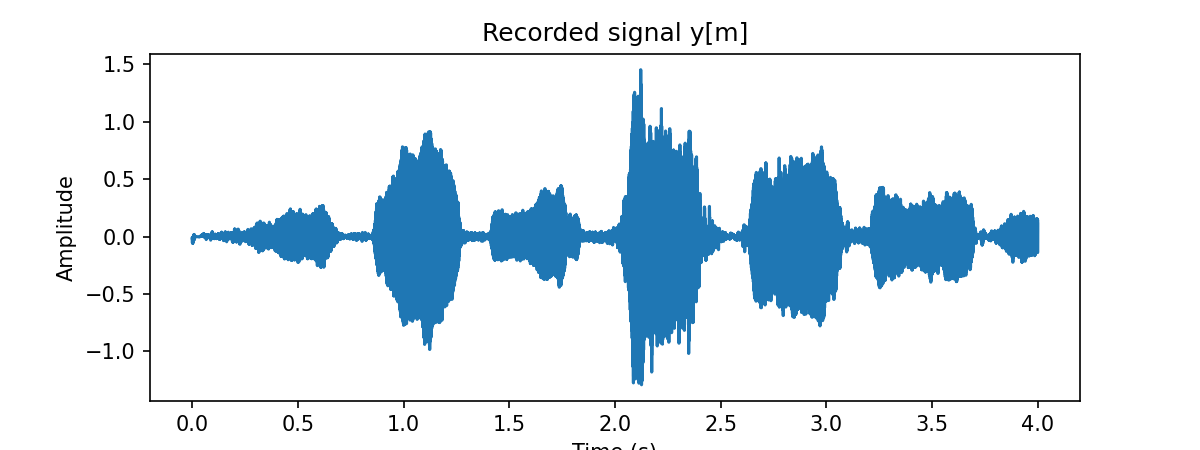

<IPython.core.display.Javascript object>


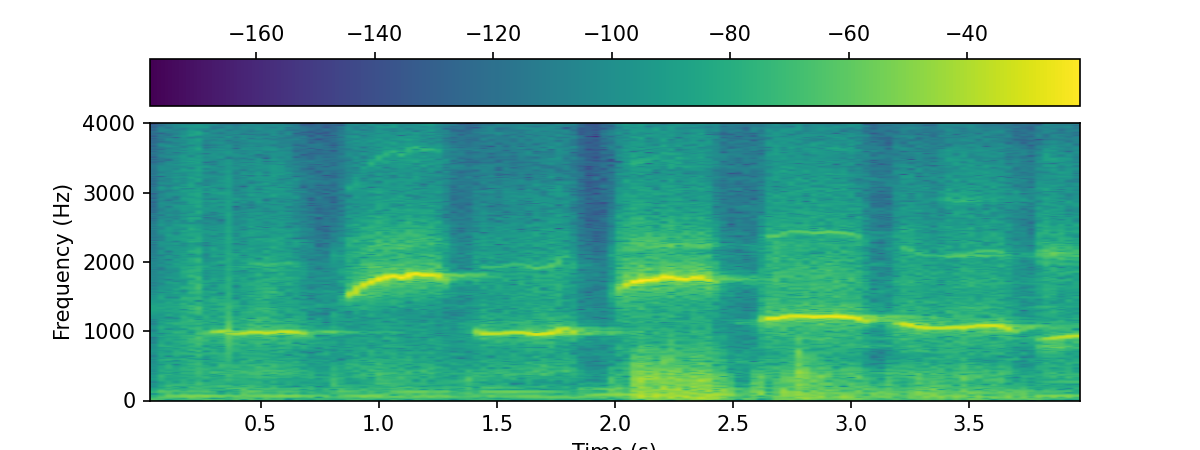

In [101]:
# Plotting
print("Data shape: ", y.shape)
print("Recorded Signal:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))

# Time domain plot
fig, axes = plt.subplots(figsize=(8, 3)) 
axes.plot(t,y, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('Recorded signal y[m]')

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(y[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
fig, axes = plt.subplots(figsize=(8, 3)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
cb = plt.colorbar(sp,ax=[axes],location='top')


### A single parameter adaptive notch filter

#### Signal model
Let us model our recorded signal in the discrete-time domain, with $n$ being the discrete-time index as follows

\begin{equation}
\label{eq:sigmodel}
y(n) =  A_{o}(n)\sin\left[ n \hspace{0.04cm}  \omega_{o}(n)  + \phi_{o}(n) \right] + g(n)
\end{equation}

where $y(n)$ is the recorded or measured signal consisting of a sinusoidal component, $A_{o}(n)\sin\left[ n \hspace{0.04cm}  \omega_{o}(n)  + \phi_{o}(n) \right]$, with time-varying parameters: amplitude $A_{o}(n)$,  phase $\phi_{o}(n)$, digital angular frequency $\omega_{o}(n) = 2 \pi f_{o}(n)/f_{s}$, where $f_{o}(n)$ is the frequency (Hz), and $f_{s}$ is the sampling frequency (Hz). This model is very broad in the sense that the remaining component, $g(n)$ can be representative of a number of signals such as a broadband desired signal, additional harmonics, or simply noise depending on the application. Given our measurement, $y(n)$, our goal is now to track the time-variation of $f_{o}(n)$ using a single parameter adaptive notch filter (ANF).


#### The constrained biquad filter


Let us first recall the biquad filter in the $z$-domain without any constraints:

\begin{equation}
H(z^{-1}) = \frac{b_{o} + b_{1} z^{-1} + b_{2}z^{-2} }{1 + a_{1} z^{-1} + a_{2}z^{-2} }.
\end{equation}  

With $b_{o} = 1$, the biquad can be expressed in polar coordinates (in the complex plane) in terms of a zero radius, $\zeta$, and zero angle $\omega_{z}$, and a pole radius, $\rho$, and pole angle, $\omega_{p}$ as follows

\begin{equation}
\label{eq:biquad_polerad}
H(z^{-1}) = \frac{(1 - \zeta e^{j\omega_{z}}  z^{-1}) (1 - \zeta e^{-j\omega_{z}} z^{-1})  }{(1 - \rho e^{j\omega_{p}} z^{-1}) (1 - \rho e^{-j\omega_{p}} z^{-1})}
\end{equation}  
where $b_{1}  = -(\zeta e^{j\omega_{z}} + \zeta e^{-j\omega_{z}}) = -2 \zeta \cos(\omega_{z})$,  $b_{2} = \zeta^{2}$, $a_{1}  =   -2 \rho \cos(\omega_{p})$,  and $a_{2} = \rho^{2}$. There are 4 parameters here that can be adjusted to configure the biquad in various ways. However, it would be more efficient if we can somehow reduce this to just one parameter, which can be updated by means of some adaptive filter. Hence in order to convert this 4-parameter biquad into a single parameter biquad that acts as a notch filter, two constraints need to be imposed:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 


2. The zeros all need to lie on the unit circle so that $\zeta = 1$. In this case the frequency component at $\omega$ would be completely attenuated and the pole at the same radial line would once again create a resonance at $\omega$, with the bandwidth of the notch filter becoming narrower as $\rho \rightarrow 1$ .

<!-- \begin{figure}
	\centering
	\includegraphics[width=\linewidth]{figs/bode_plots_biquad_edit}
	\caption{(Left) Pole-zero plot of a constrained biquad IIR filter configured as a notch filter. The poles and zeros lie on the same radial line defined by $\omega = \pi/4$, where the zeros are placed on the unit circle and the poles at a distance $\rho = 0.8$. (Right) The corresponding magnitude and phase response. A notch is clearly visible at $\omega = \pi/4$ with a very narrow bandwidth due to $\rho = 0.8$. }
	\label{fig:bodeplotsbiquadedit}
\end{figure} -->

Imposing these constraints then results in the constrained biquad filter:

\begin{align}
\label{eq:const_biquad_polerad}
H(z^{-1}) &= \frac{(1 - e^{j\omega}  z^{-1}) (1 -  e^{-j\omega} z^{-1})  }{(1 - \rho e^{j\omega} z^{-1}) (1 - \rho e^{-j\omega} z^{-1})} \nonumber \\
&= \frac{1 - 2 \cos(\omega) z^{-1} + z^{-2} }{1 - 2 \rho \cos(\omega) z^{-1} + \rho^{2} z^{-2}} \nonumber \\
& = \frac{1 - a z^{-1} + z^{-2} }{1 - \rho a z^{-1} + \rho^{2} z^{-2}} 
\end{align}  
where $a \triangleq 2 \cos(\omega) = 2 \cos (2 \pi f/f_{s})$ is the only parameter we need to estimate (since it appears in both the numerator and denominator) and is directly related to the centre frequency, $f$, of the notch filter. Consequently, by adapting the $a$ coefficient, the centre frequency of the notch filter also changes resulting in an ANF. 

Before proceeding to develop an adaptive algorithm to update $a$, let's first quickly have a look at the pole-zero plot of the biquad filter and the subsequent magnitude/phase response. In the following code, we've put together an interactive plot where you can vary $\rho$ and $\omega$ to see the effect on the position of the poles and the corresponding magnitude and phase response.


<IPython.core.display.Javascript object>


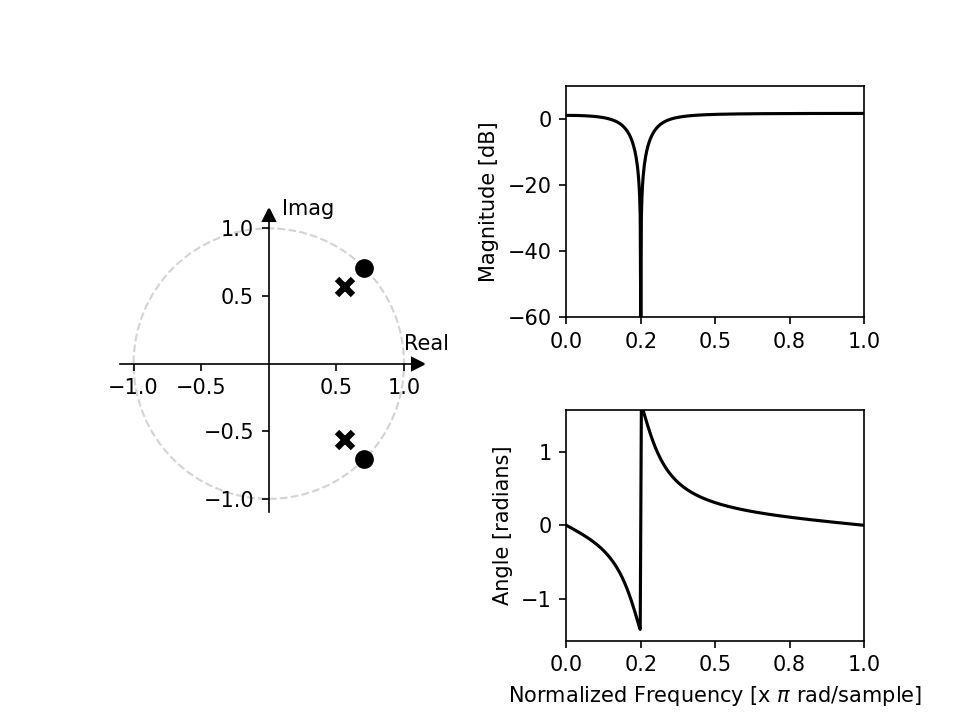

Move the slider to see how the filter changes with the pole radius and centre frequency!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.95, step=0.01), FloatSlider(value=0.7853…

In [102]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-60, 10])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Angle [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi/2, np.pi/2])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, omega=np.pi/4):
    
    zeta = 0.9999; # zero radius ~= 1

    bo = 1;
    b1 = -2*np.cos(omega)*zeta;
    b2 = zeta**2;

    a1 = -2*np.cos(omega)*rho;
    a2 = rho**2;

    b = [bo,b1,b2];
    a = [1,a1,a2];

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the pole radius and centre frequency!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.95,0.01), omega=(0,np.pi,np.pi/16)); 



### Least Mean Square Adaptive Notch Filter (LMS-ANF)
$\newcommand{\ahat}{\hat{{a}}}$

Let's recall the constrained biquad filter expression:

\begin{align}
\label{eq:const_biquad_polerad} \tag{LMS.1}
H(z^{-1}) & = \frac{1 - a z^{-1} + z^{-2} }{1 - \rho a z^{-1} + \rho^{2} z^{-2}} 
\end{align} 

The strategy here is that we can choose $\rho$, which effectively controls the filter bandwidth, and then we need to find an update equation for $a$, which will consequently update the frequency to be notched, $\omega$, since $a \triangleq 2 \cos(\omega) = 2 \cos (2 \pi f/f_{s})$.

An efficient method to estimate $a$ can be derived by considering the direct form II of the constrained biquad filter as illustrated in Fig. 1. The implementation equations are given as  
\begin{align}
\label{eq:biquadeqn_state} \tag{LMS.2}
s(n) &=  y(n) + \rho a(n-1) s(n-1) - \rho^{2} s(n-2) \\
\label{eq:biquadeqn_error} \tag{LMS.3}
e(n) &= s(n) - a(n-1)s(n-1) + s(n-2)
\end{align}

where $y(n)$ is the input to the constrained biquad filter (our measured signal), $e(n)$ is the output, and $s(n)$ is introduced as an auxiliary variable. In this form, the biquad filter is explicitly split into two sections. The first is a two-pole resonance IIR filter illustrated on the left side of Fig. 1, corresponding to the denominator of \eqref{eq:const_biquad_polerad} and whose difference equation is given by \eqref{eq:biquadeqn_state}. The second section is a finite impulse response (FIR) two-zero notch filter illustrated on the right side of Fig.1, corresponding to the numerator of \eqref{eq:const_biquad_polerad} and whose difference equation is given by \eqref{eq:biquadeqn_error}.

<br>
<br>

<div>
<img src="img/biquad_block.png" width="650"/>
    <p style="text-align:center">Fig. 1 - Direct Form II of the constrained biquad filter</p>
</div>

<br>
<br>


We can now proceed to estimate $a$ by minimising the mean-squared output signal power of the filter, i.e. minimising the mean-square of $e(n)$. In [Travassos-Romano1988](https://ieeexplore.ieee.org/document/196857), it was proposed to only update the FIR section of the biquad filter, i.e. estimate the coefficient $a$ in the FIR section, and since this $a$ occurs in both the numerator and denominator in \eqref{eq:const_biquad_polerad}, this estimate can be simply copied to the IIR section of the biquad filter. An LMS algorithm can then be used to estimate $a$ by making use of \eqref{eq:biquadeqn_error} as follows  

\begin{align}
\hat{a}(n) &=  \hat{a}(n-1) + \mu \left( - \frac{\partial e^{2}(n)}{\partial a(n-1)}\right) \nonumber \\
&= \hat{a}(n-1) +  2 \hspace{0.01cm} \mu \hspace{0.05cm} s(n-1)   e(n) 
\label{eq:lmsupdate}
\end{align}

where $\mu$ is the step size parameter. 



The algorithm for computing frequency estimates using such an LMS update is given in Algorithm 1 and we subsequently refer to the resulting frequency tracker as LMS-ANF. In Algorithm 1, $N$ is the length of the signal, $y(n)$, and due to the $s(n-2)$ term, we simply start the for loop from $n=2$ and initialize $s(0)$ and $\ahat(1),s(1)$. Since $\arccos(\ahat(n)/2)$ does not exist for $|\ahat(n)| > 2$, we have additionally imposed a constraint on the values of $\ahat(n)$ such that $\ahat(n)$ is re-initialized to zero when $|\ahat(n)| > 2$, {i.e. we restart the algorithm\footnote{{This is certainly not the only strategy to deal with out of range values for $\ahat(n)$, but an investigation into this aspect of the ANF is out of the scope of this work.}} with an initial frequency estimate at half of the Nyquist frequency.} {By defining the computational complexity as the number of multiplications per recursion, from Algorithm 1, we can deduce that the LMS-ANF has a computational complexity of 11 multiplications per recursion.} It should also be noted that in addition to obtaining a sample-by-sample update of the estimated frequency, we also obtain a sample-by-sample update of the output (i.e. adaptive notch-filtered input signal), $e(n)$, however we are only concerned with the former as it pertains to the frequency tracker. 

<br>
<br>

<div>
<img src="img/LMS_algo.png" width="500"/>
</div>

<br>

So now let's code this algorithm!

In [110]:
# We will firstly make this algorithm a function that we will then use to process our recorded signal.

def lms_anf (y, fs, rho, mu):
    '''
    Least Mean Square (LMS) Adaptive Notch Filter
    James M. Kates, “Feedback Cancellation in Hearing Aids: Results from a Computer Simulation,” IEEE Transactions on Signal Processing, vol. 39, no. 3, pp. 553–562, 1991.
    
    Input arguments:
        y       - input data vector (Lx1)
        fs      - sampling frequency (Hz)
        rho     - pole raduis (value between 0 and 1, with values closer to 1 creating a narrower notch)
        mu      - Step size parameter for LMS
    
    Returns:
        f_lms   - Estimated frequency over time (Lx1)
        a_lms   - Estimated filter coefficient over time (Lx1)
        e_lms   - Outpupt from notch filter (Lx1)
        
    '''  

    s_lms = np.zeros(len(y)) # intermediate variable of ANF
    e_lms = np.zeros(len(y)) # output of ANF
    a_lms = np.zeros(len(y)) # coefficient to be updated
    f_lms = np.zeros(len(y)) # frequency to be tracked
    
    for n in np.arange(2,len(y),1): # start loop from two samples ahead because we need samples at m-1 and m-2 
    
        s_lms[n] = y[n] + rho*a_lms[n-1]*s_lms[n-1] - (rho**2)*s_lms[n-2]
        e_lms[n] = s_lms[n] - a_lms[n-1]*s_lms[n-1] + s_lms[n-2]
        a_lms[n] = a_lms[n-1] + 2*mu*e_lms[n]*s_lms[n-1]
    
        if (a_lms[n] > 2) or (a_lms[n] < -2):
#             print('a = '+str(a_lms[n])+ ' is out of range, resetting to 0')
            a_lms[n] = 0 # reset coefficient if a is out of range to compute acos

        omega_hat_lms = np.arccos(a_lms[n]/2)
        f_lms[n] = (omega_hat_lms*fs)/(2*np.pi) # estimated frequency
        
    return f_lms, a_lms, e_lms


### Result of the LMS-ANF

Okay now that we have coded the LMS-ANF, we can apply it to the signal we measured. 
We will do the following:

1. Plot a spectrogram of the recorded signal $y(n)$ and listen to it
2. Overlay the tracked frequency from the LMS-ANF
3. Plot the spectrogram of the output signal $e(n)$ and listen to it.
4. Interactive plot of the frequency response of the LMS-ANF

<IPython.core.display.Javascript object>


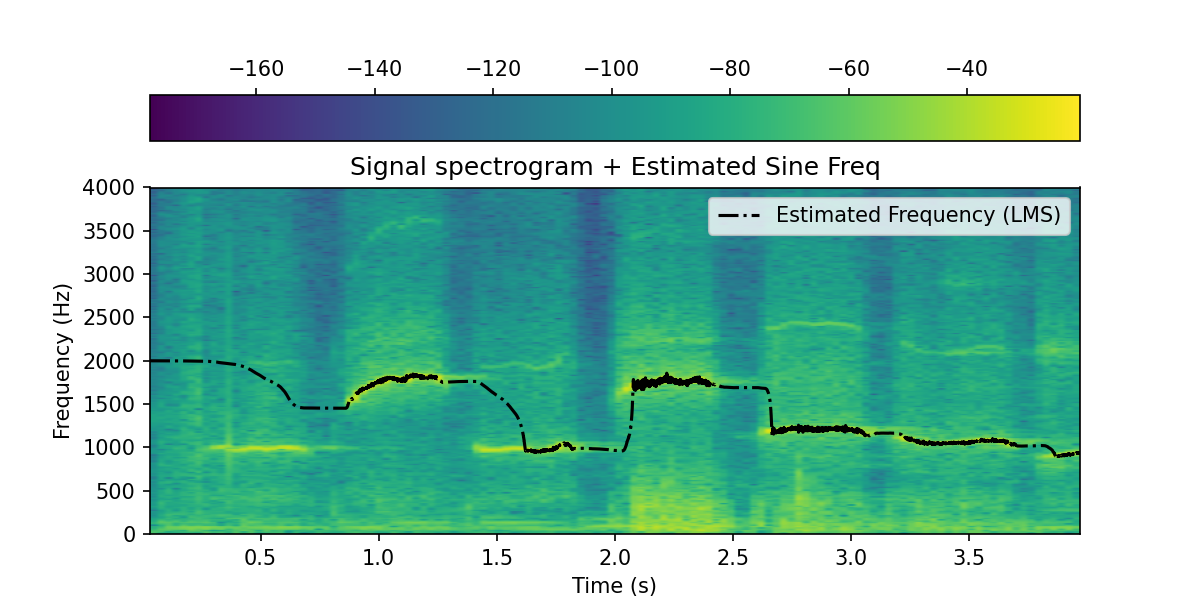

Listen to the recorded signal:


<IPython.core.display.Javascript object>


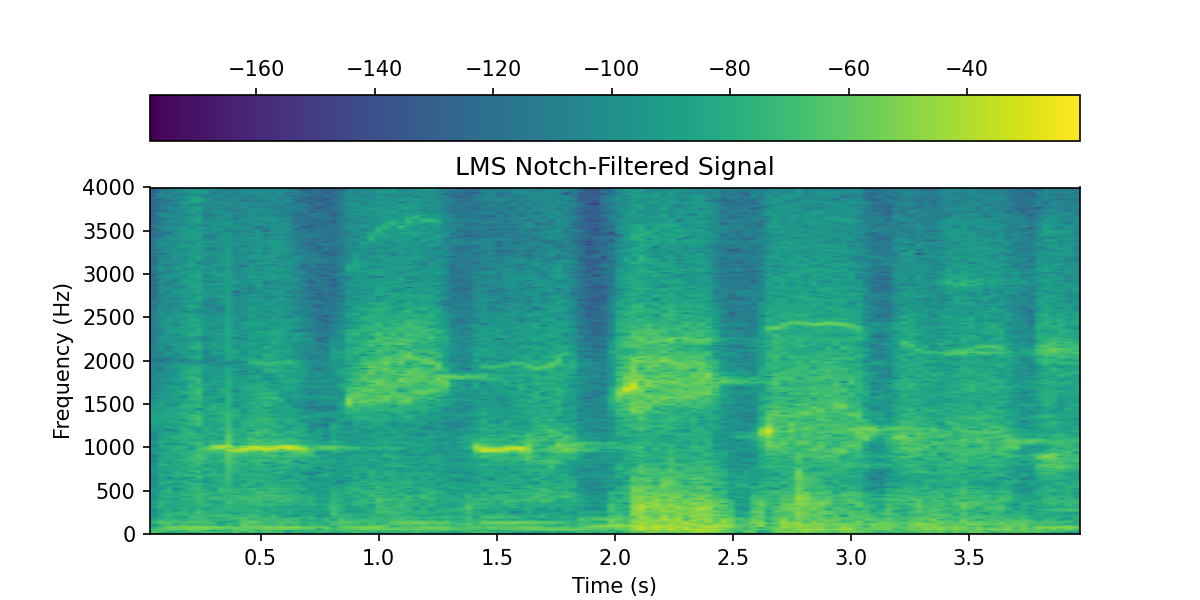

Listen to the LMS Notch Filtered Signal:


<IPython.core.display.Javascript object>


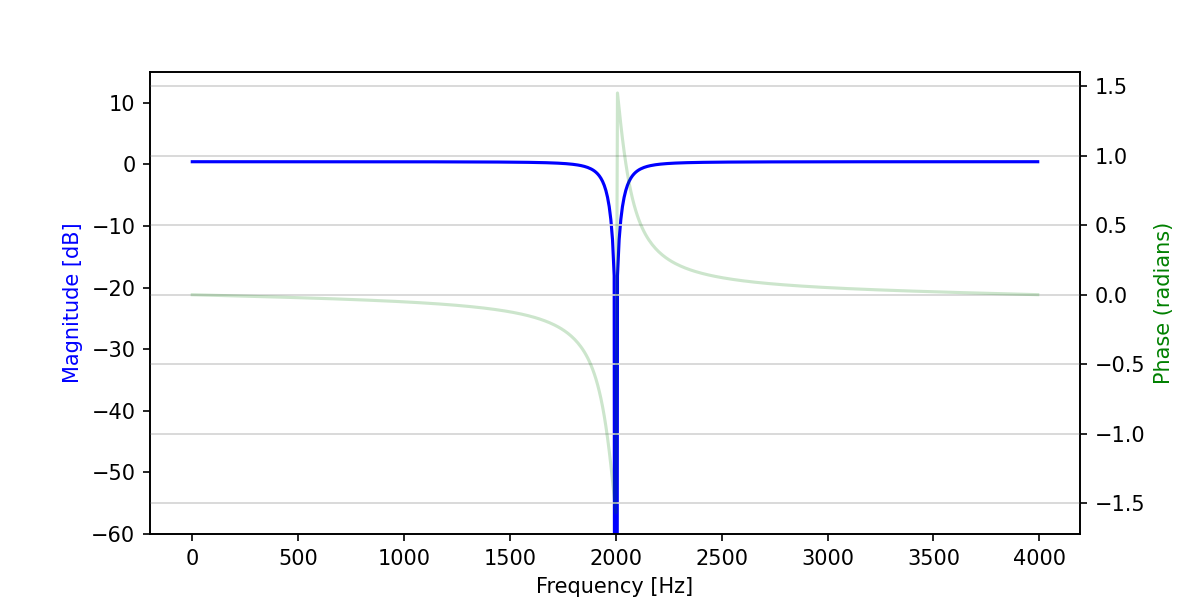

Move the slider to see how the filter changes with time! (m is the sample index).


interactive(children=(IntSlider(value=0, description='n', max=31999), Output()), _dom_classes=('widget-interac…

In [104]:
##### Initial paramter set up #######

L = len(y)    # Total duration of signal (number of samples)
n = np.arange(0,L,1) # range of samples
tt = n/fs   # time range of signal

# You can very the pole radius and step size parameter to observe how the performance changes.
rho = 0.95 
mu = 0.01

# Apply the LMS-ANF algorithm
f_lms, a_lms, e_lms = lms_anf (y, fs, rho=rho, mu=mu) 


####### Computing spectrograms ######

# Spectrogram parameters
nfft = 512         # number of points for the FFT 
noverlap = nfft//2  # Spectrogram overlap (make it 50 %)

# Spectrogram of the input signal
f_sg, t_sg, Z_mag = signal.spectrogram(y[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image" for the imshow function to plot spectrogram

# Spectrogram of the output
f_sg, t_sg, E_lms_mag = signal.spectrogram(e_lms, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
E_lms_dB = 10*np.log10(E_lms_mag**2) # convert the magnitude to dB

min_dB = -140
max_dB = -40


###### Plotting and listening! #####

# 1 & 2. Recorded signal and freq. track

fig, axes = plt.subplots(figsize=(8, 4)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent, vmin=np.min(Z_dB),vmax=np.max(Z_dB))
axes.plot(tt,f_lms,'-.',color='black',markersize=0.1,label='Estimated Frequency (LMS)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_xlim(t_sg[0], t_sg[-1])
axes.set_title('Signal spectrogram + Estimated Sine Freq')
cb = plt.colorbar(sp,ax=[axes],location='top', pad=0.1)
axes.legend()

print("Listen to the recorded signal:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))


# 3. Output signal (LMS adaptive notch filtered)

fig, ax = plt.subplots(figsize=(8, 4)) 
sp2 = ax.imshow(E_lms_dB, origin='lower',aspect='auto',extent=extent, vmin=np.min(Z_dB),vmax=np.max(Z_dB))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('LMS Notch-Filtered Signal')
axes.set_xlim(t_sg[0], t_sg[-1])
cb = plt.colorbar(sp2,ax=[ax],location='top',pad=0.1)

print("Listen to the LMS Notch Filtered Signal:")
IPython.display.display(Audio(e_lms.T, rate=fs,normalize=True))


# # Time domain plot
# fig, axes = plt.subplots(figsize=(8, 4)) 
# axes.plot(t,e_lms, label = 'Desired')
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('Amplitude')
# axes.set_title('LMS Notch-Filtered Signal')


# 4. Freq. response of LMS-ANF over time

# These are the filter coefficients for the biquad filter:
b =[1,-a_lms[0],1]
a =[1, -rho*a_lms[0], rho**2]

w, h = signal.freqz(b,a)
freq_axis = w*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots(figsize=(8, 4))
linelms, = ax1.plot(freq_axis, 20 * np.log10(abs(h)), 'b-',label='LMS')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-60, 15])
ax2 = ax1.twinx()
linephlms, = ax2.plot(freq_axis, angles, 'g-',alpha=0.2)
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True,color='lightgrey')
ax2.axis('tight')
plt.show()

def update(n = 0):
    
    a1_lms = a_lms[n]
    blms =[1,-a1_lms,1]
    aden =[1, -rho*a1_lms, rho**2]
    wlms, hlms = signal.freqz(blms,aden)
    angles_lms = np.unwrap(np.angle(hlms))

    linelms.set_data(freq_axis, 20 * np.log10(abs(hlms)))
    linephlms.set_data(freq_axis, angles_lms)
    
    
print('Move the slider to see how the filter changes with time! (m is the sample index).')
interact(update, n = (0,L-1,1)); 


### Kalman-Based Adaptive Notch Filter (KalmANF)
$\newcommand{\xhat}{\hat{\mathbf{x}}}$
So we've seen how the LMS-ANF works, and it is not too bad! But we can always try to do better :)

An alternative way we can represent this type of ANF based on a constrained biquad is by a [state-space representation](https://en.wikipedia.org/wiki/State-space_representation), which is a common framework for dynamic linear systems, from which one can apply a Kalman filter to estimate the so-called state. For the ANF, the state should contain the parameter $\ahat$ as this is the time-parameter we would like to estimate. But firstly, let's briefly re-call the state-space representation and the corresponding Kalman filter to estimate the state. 


\begin{align}
\label{eq:state_space_model_stateeqn} \tag{KAL.1}
\mathbf{x}(n) &= \mathbf{C} \mathbf{x}(n-1) + \mathbf{w}(n) \\
\label{eq:state_space_model_measeqn} \tag{KAL.2}
\mathbf{z}(n) &= \mathbf{H} \mathbf{x}(n) + \mathbf{v}(n)
\end{align}


where $\mathbf{x}(n) \in \mathbb{R}^{L}$ is the state vector at time $n$, $\mathbf{C} \in \mathbb{R}^{L \times L}$ is the state-transition matrix, $\mathbf{w}(n) \in \mathbb{R}^{L}$ is the process noise vector, which is modelled as a zero-mean, Gaussian process with covariance matrix $\mathbf{Q} \in \mathbb{R}^{L \times L}$,   $\mathbf{z}(n) \in \mathbb{R}^{M}$ is the measurement vector, $\mathbf{H} \in \mathbb{R}^{M \times L}$ is the measurement matrix, and $\mathbf{v}(n) \in \mathbb{R}^{M}$ is the measurement noise vector, also modelled as a zero-mean, Gaussian process but with covariance matrix $\mathbf{R} \in \mathbb{R}^{M \times M}$.



For dynamical systems which can be described in the state-space form of \eqref{eq:state_space_model_stateeqn} and \eqref{eq:state_space_model_measeqn}, the state-vector at time $n$ can be estimated using a Kalman filter. The Kalman filter consists of two steps: (i) a prediction (or update) stage and, (ii) an estimation (or measurement) stage, which are performed in a recursive manner, and are given by the following equations

\begin{align}
\label{eq:kf_statevectupdate} \tag{KAL.3}
\xhat(n | n-1) &= \mathbf{C}\xhat( n-1) \\
\label{eq:kf_covmatprederr} \tag{KAL.4}
\hat{\mathbf{P}}(n | n-1) &= \mathbf{C}\hat{\mathbf{P}}(n-1)\mathbf{C}^{T} + \mathbf{Q}\\
\label{eq:kf_kalmangain} \tag{KAL.5}
\mathbf{K}(n) &= \hat{\mathbf{P}}(n | n-1) \mathbf{H}^{T} \left(\mathbf{H}  \hat{\mathbf{P}}(n | n-1) \mathbf{H}^{T}  + \mathbf{R}   \right)^{-1} \\
\label{eq:kf_errorsig} \tag{KAL.6}
\mathbf{v}(n) &= \mathbf{z}(n) - \mathbf{H}\xhat(n | n-1)\\
\label{eq:kf_statevectestimate} \tag{KAL.7}
\xhat(n) &= \xhat(n | n-1) + \mathbf{K}(n)\mathbf{v}(n)\\
\label{eq:kf_covmatesterror} \tag{KAL.8}
\hat{\mathbf{P}}(n)&= \left[ \mathbf{I} -  \mathbf{K}(n)\mathbf{H} \right] \hat{\mathbf{P}}(n | n-1)
\end{align}

where $\mathbf{K}(n)$ is the Kalman gain, the notation $\xhat(n|n-1)$ denotes a prediction of $\mathbf{x}(n)$ based on measurement samples up to time $n-1$, and the prediction error is defined as $\mathbf{x}(n) - \xhat(n|n-1)$ with a covariance matrix, $\mathbf{P}(n)$, whose estimate is denoted as $\hat{\mathbf{P}}(n)$. The first two equations, \eqref{eq:kf_statevectupdate} and \eqref{eq:kf_covmatprederr}, are the prediction equations, which update the state and the covariance matrix of the prediction error from measurement samples up to time $n-1$. The subsequent equations are the estimation equations. $\mathbf{v}(n)$ in \eqref{eq:kf_errorsig} is also referred to as the innovation signal, which is the error between the new measurement at time $n$ and the prediction based on measurement samples up to time $n-1$, and is used to update the state-vector estimate at time $n$ in \eqref{eq:kf_statevectestimate} along with the Kalman gain, $\mathbf{K}(n)$, computed in \eqref{eq:kf_kalmangain}. The prediction error covariance matrix at time $n$ is finally updated in \eqref{eq:kf_covmatesterror}, and the entire sequence of equations is repeated for the next time index. 


By following the strategy of estimating $a$ in the FIR section of the constrained biquad filter from Fig. 1 and copying the estimate to the IIR section, we can use LMS.2 and LMS.3 (see previous cell) to define a state-space model corresponding to the form of \eqref{eq:state_space_model_stateeqn} and 
\eqref{eq:state_space_model_measeqn} as follows:

\begin{align}
\label{eq:biquad_statespace_state} \tag{KAL.9}
\underbrace{\begin{bmatrix} a(n)  \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n)} &= \underbrace{\begin{bmatrix} 1 & 0  \\ 
	0 & 1 \end{bmatrix}}_{\mathbf{C}}  \underbrace{\begin{bmatrix} a(n-1)  \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n-1)}  + \underbrace{\begin{bmatrix} w(n)  \\ 
	0 \end{bmatrix}}_{\mathbf{w}(n)} \\
\label{eq:biquad_statespace_meas} \tag{KAL.10}
\underbrace{s(n)}_{\mathbf{z}(n)}  &= \underbrace{\begin{bmatrix} s(n-1)  & -s(n-2) \end{bmatrix}}_{\mathbf{H}(n)} \underbrace{\begin{bmatrix} a(n)  \\ 
	1 \end{bmatrix}}_{\mathbf{x}(n)} + \underbrace{e(n)}_{\mathbf{v}(n)}
\end{align}


Focusing firstly on \eqref{eq:biquad_statespace_meas} and comparing with \eqref{eq:state_space_model_measeqn}, it is evident that we have defined $s(n)$ as our measurement, which is a scalar. Although we do not explicitly measure $s(n)$, it is a function of the input signal, $y(n)$, and therefore we can use (LMS.2) with $a(n-1) = \ahat(n-1)$ to obtain a value for $s(n)$. We can also observe that the measurement matrix, $\mathbf{H}(n)$, is now time-varying and depends on two previous measurement samples. The measurement noise vector is also simply a scalar and is the error, $e(n)$, we want to minimize in the ANF context. 

Finally we  can observe that the state vector, $\mathbf{x}(n)$ is a function of $a(n)$, which is the parameter that we want to estimate. With the measurement equation defined, the state equation of \eqref{eq:biquad_statespace_state} follows directly from \eqref{eq:state_space_model_stateeqn}, where $\mathbf{C}$ is simply an identity matrix and $\mathbf{w}(n)$ has one non-zero value, $w(n)$, since it is only $a(n)$ that needs to be updated.

We can simply proceed to use the equations \eqref{eq:kf_statevectupdate} - \eqref{eq:kf_covmatesterror} to obtain an estimate for $a(n)$. However, because of the low dimensionality of the state-space equations defined in \eqref{eq:biquad_statespace_state} and \eqref{eq:biquad_statespace_meas}, we can also substitute them into  \eqref{eq:kf_statevectupdate} - \eqref{eq:kf_covmatesterror} to obtain simpler and more intuitive expressions to understand how $a(n)$ is being estimated. 


Since $\mathbf{C}$ is an identity matrix, \eqref{eq:kf_statevectupdate} is simply
\begin{align}
\label{eq:kanf_statevectupdate} \tag{KAL.11}
%\xhat(n | n-1) &= \xhat( n-1) \nonumber \\
\xhat(n | n-1) = \begin{bmatrix} \ahat(n|n-1)  \\ 
1 \end{bmatrix}					& = \begin{bmatrix} \ahat(n-1)  \\ 
					1 \end{bmatrix} 
\end{align}


We initialize the estimate of the covariance matrix of the prediction error, $\hat{\mathbf{P}}(n)$, and the covariance matrix of the process noise, $\mathbf{Q}$ with only one non-zero entry so that \eqref{eq:kf_covmatprederr} reduces to


\begin{align}
\label{eq:kanf_covmatprederr} \tag{KAL.12}
\hat{\mathbf{P}}(n | n-1)  = \begin{bmatrix}
\hat{p}(n | n-1) & 0 \\
0 & 0
\end{bmatrix} & =  \begin{bmatrix}
							\hat{p}(n-1) + q & 0 \\
							0 & 0
							\end{bmatrix} 
\end{align}

where $q$ is the variance of $w(n)$, which is a hyperparameter of the proposed algorithm.

Since the measurement equation of \eqref{eq:biquad_statespace_meas} is scalar, the covariance of the measurement noise boils down to the variance of $e(n)$, which we denote as $r$, another hyperparameter. Using the time-varying measurement matrix, $\mathbf{H}(n)$ from \eqref{eq:biquad_statespace_meas} and $\hat{\mathbf{P}}(n | n-1) $ from \eqref{eq:kanf_covmatprederr}, the Kalman gain follows from \eqref{eq:kf_kalmangain} as

\begin{align}
\label{eq:kanf_kalmangain} \tag{KAL.13}
\mathbf{K}(n) &=  \frac{s(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }   } \begin{bmatrix}
1 \\
0 
\end{bmatrix}
%
\end{align} 



From \eqref{eq:kf_statevectestimate} we then obtain the update equation for the state vector. Since the second element in the state vector is always 1 and the Kalman gain is zero for this entry, we will in fact just have a scalar update equation as follows:

\begin{align}
\label{eq:kanf_filterupdate} \tag{KAL.14}
\ahat(n) &= \ahat(n-1) + \frac{s(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }   }   e(n)
\end{align}

where using \eqref{eq:kf_errorsig}, $e(n)$ is given by

\begin{align}
\label{eq:kanf_error} \tag{KAL.15}
e(n) &= s(n) -  s(n-1) \ahat(n-1)   + s(n-2) 
\end{align}

which is identical to LMS.3 but with $a(n-1) = \hat{a}(n-1)$.

Finally from \eqref{eq:kf_covmatesterror}, the update of the first and only non-zero element of the covariance matrix of the prediction error is


\begin{align}
\label{eq:kanf_prederror} \tag{KAL.16}
\hat{p}(n) &= \left(1 - \frac{s^{2}(n-1)} {s^{2}(n-1) + \frac{r}{\hat{p}(n | n-1) }} \right) \hat{p}(n | n-1)
\end{align}


It can now be seen that \eqref{eq:kanf_filterupdate} is indeed in the form of a normalized LMS (NLMS) filter update, {with a time-varying step size of  $1/ \left[s^{2}(n-1) + r/\hat{p}(n | n-1) \right]$,} where the term $s^{2}(n-1)$ provides the normalization and  $r/\hat{p}(n | n-1) $ acts as a time-varying regularization parameter. As opposed to having to choose this regularization parameter in a heuristic manner, an optimal value is now defined in the Kalman filter context as the ratio of the variance of the measurement noise to the variance of the prediction error obtained from measurements samples up to time $n-1$. We also note that a similar, yet time-invariant expression for the NLMS parameter was obtained in a Bayseian framework.


A summary of the KalmANF frequency tracker is given in Algorithm 2. As with the LMS-ANF, due to the $s(n-2)$ term, we simply start the for loop from $n=2$ and initialize $s(0)$, $\ahat(1),s(1)$, and $\hat{p}(1)$. The constraints are also imposed on $\ahat(n)$ to ensure $ \arccos(\ahat(n)/2)$ exists. {We can also deduce that the KalmANF has a computational complexity of 14 multiplications per recursion (in line 7, only two multiplications are counted since $k(n)$ would have been computed in line 4), which is the same order of magnitude as the LMS-ANF.}

<br>
<br>

<div>
<img src="img/KalMANF_algo.png" width="500"/>
</div>

Time to code this algorithm!

In [109]:
# We will also make this algorithm a function that we will then use to process our recorded signal.

def kalmanf (y, fs, rho, q, r):
    
    '''
    Kalman-Based Adaptive Notch Filter (KalmANF)
    

    Input arguments:
        y       - input data vector (Lx1)
        fs      - sampling frequency (Hz)
        rho     - pole raduis (value between 0 and 1, with values closer to 1 creating a narrower notch)
        q       - Covariance of process noise
        r       - Covariance of measurement noise
        
    Returns:
        f_kal   - Estimated frequency over time (Lx1)
        a_kal   - Estimated filter coefficient over time (Lx1)
        e_kal   - Output from notch filter (Lx1)
        
    '''  


    s_kal = np.zeros(len(y)) # intermediate variable of ANF
    e_kal = np.zeros(len(y)) # output of ANF
    a_kal = np.zeros(len(y)) # coefficient to be updated
    f_kal = np.zeros(len(y)) # frequency to be tracked
    
    p_cov = 0 # initialise covariance of the error
    K = np.zeros(len(y)) # Kalman gain
        
    for n in np.arange(2,len(y),1): # start loop from two samples ahead because we need samples at m-1 and m-2 
        
        # Prediction
        # a(n|n-1) is simply a(n-1) since the state transition matrix is an identiy
        p_cov = p_cov + q; # update covariance of prediction error
        
        
        # Estimation
        s_kal[n] = y[n] + rho*s_kal[n-1]*a_kal[n-1] - (rho**2)*s_kal[n-2] # Define s_kal from data
        K[n] = (s_kal[n-1])/( (s_kal[n-1]**2) + r/p_cov )
        e_kal[n] = s_kal[n] - s_kal[n-1]*a_kal[n-1] + s_kal[n-2] 
        a_kal[n] = a_kal[n-1] + K[n]*e_kal[n]
    
        # Update covariance of error
        p_cov = (1 - K[n]*s_kal[n-1])*p_cov
        
        # Compute frequency
        if (a_kal[n] > 2) or (a_kal[n] < -2):
#             print('a = '+str(a_kal[n])+ ' is out of range, resetting to 0')
            a_kal[n] = 0 # reset coefficient if a is out of range to compute acos
        
        omega_hat_kal = np.arccos(a_kal[n]/2)
        f_kal[n] = (omega_hat_kal*fs)/(2*np.pi) # estimated frequency
    
    return f_kal, a_kal, e_kal

### Result of the KalmANF and comparing it to LMS-ANF

We will now make the same plots as we did with the LMS-ANF, but make a comparison to the KalmANF.
We need to note that whereas the LMS-ANF has the step-size parameter, $\mu$ to tune, with the KalmANF, we need to set both variance of the process noise, $q$, and the variance of the measurement noise, $r$. In practice however, one may set $r$ to a fixed value and then tune $q$ accordingly, since it is the ratio of these two parameters which are important for setting the appropriate regularization parameter and consequently the time-varying step size.

So let's do the following:

1. Plot a spectrogram of the recorded signal $y(n)$ and listen to it
2. Overlay the tracked frequency from the KalmANF and LMS-ANF
3. Plot the spectrogram of the output signal $e(n)$ from the KalmANF and listen to it.
4. Interactive plot of the frequency response of the KalmANF and LMS-ANF

<IPython.core.display.Javascript object>


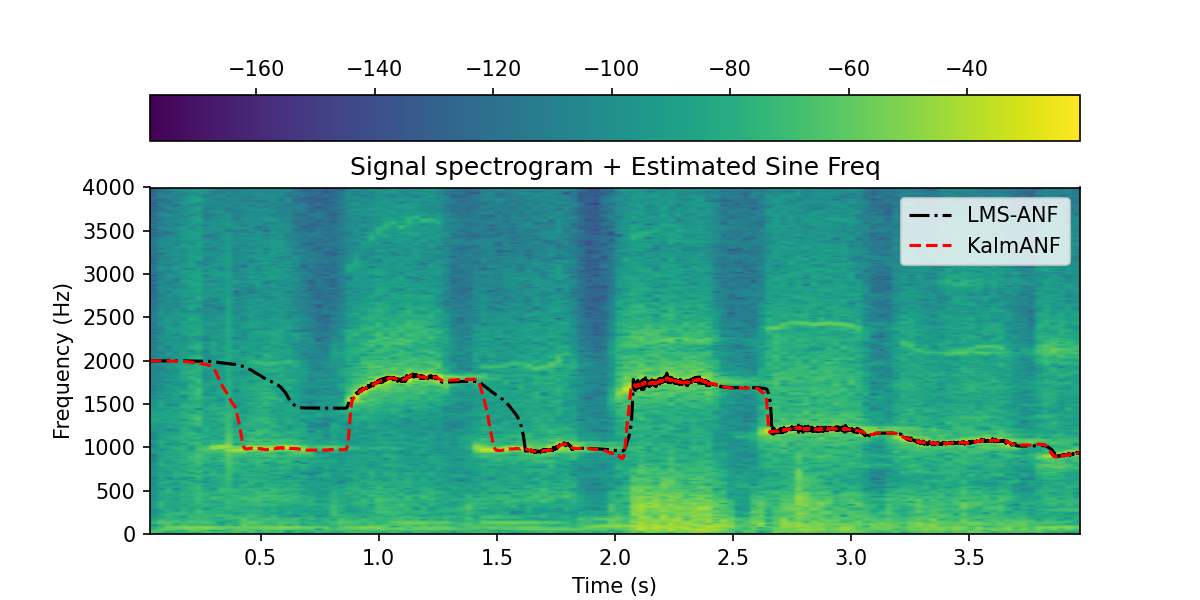

Listen to the recorded signal:


<IPython.core.display.Javascript object>


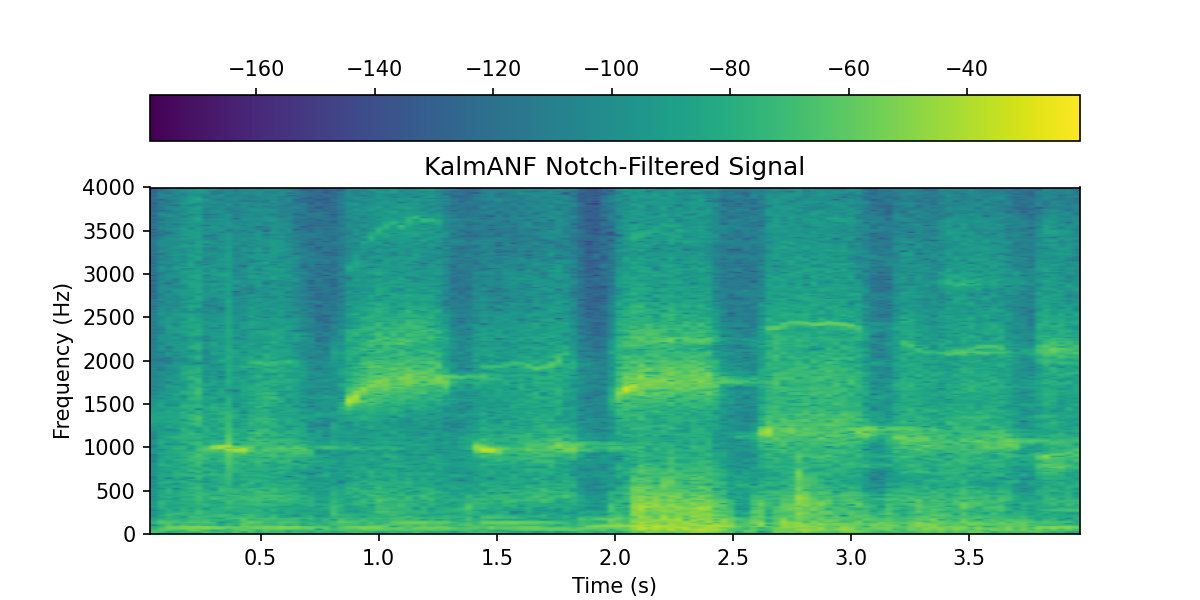

Listen to the KalmANF Notch Filtered Signal:


<IPython.core.display.Javascript object>


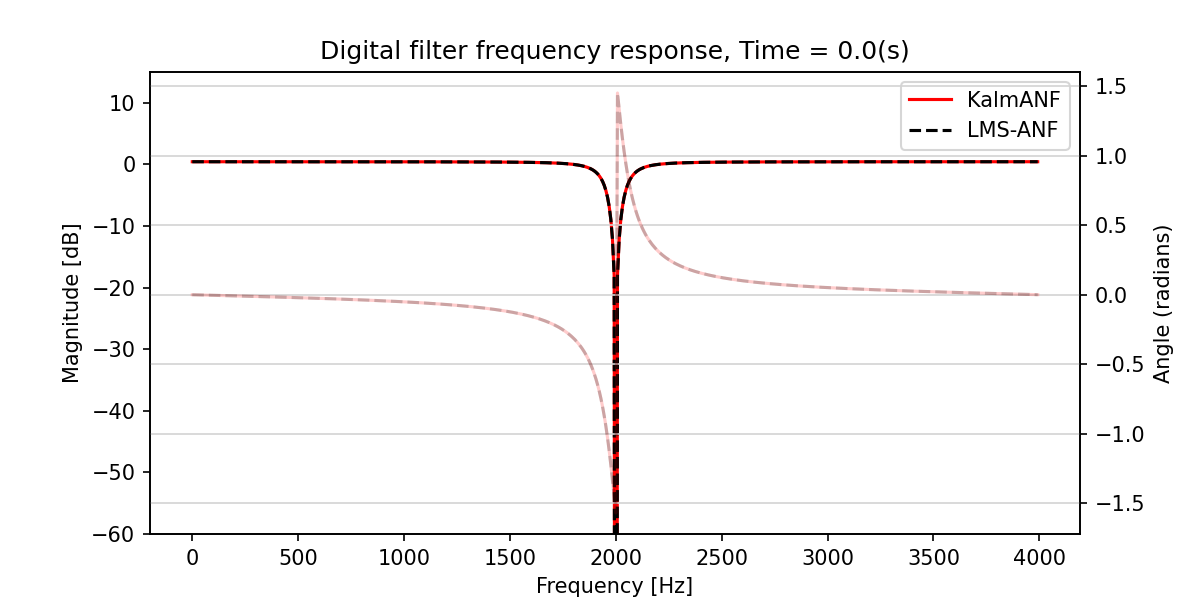

Move the slider to see how the filter changes with time! (m is the sample index).


interactive(children=(IntSlider(value=0, description='n', max=31999), Output()), _dom_classes=('widget-interac…

In [115]:
##### Initial paramter set up #######

# You can very the pole radius, q, and r to observe how the performance changes.
rho = 0.95
q= 1e-4
r= 1

# Apply the KalmANF algorithm
f_kal, a_kal, e_kal = kalmanf (y, fs, rho, q=q, r=r) 


# # If you quickly want to change something on the LMS-ANF algorithm without going back to the previous cell,
# # uncomment the following lines:

mu = 0.01
f_lms, a_lms, e_lms = lms_anf (y, fs, rho=rho, mu=mu) 


####### Computing spectrograms ######


# Spectrogram of the output from KalmANF
f_sg, t_sg, E_kal_mag = signal.spectrogram(e_kal, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
E_kal_dB = 10*np.log10(E_kal_mag**2) # convert the magnitude to dB

min_dB = -140
max_dB = -40


###### Plotting and listening! #####

# 1 & 2. Recorded signal and freq. track

fig, axes = plt.subplots(figsize=(8, 4)) 
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent, vmin=np.min(Z_dB),vmax=np.max(Z_dB))
axes.plot(tt,f_lms,'-.',color='black',markersize=0.1,label='LMS-ANF')
axes.plot(tt,f_kal,'--',color='red',markersize=0.1,label='KalmANF')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_xlim(t_sg[0], t_sg[-1])
axes.set_title('Signal spectrogram + Estimated Sine Freq')
cb = plt.colorbar(sp,ax=[axes],location='top', pad=0.1)
axes.legend()

print("Listen to the recorded signal:")
IPython.display.display(Audio(y.T, rate=fs,normalize=True))


# 3. Output signal (LMS adaptive notch filtered)

fig, ax = plt.subplots(figsize=(8, 4)) 
sp2 = ax.imshow(E_kal_dB, origin='lower',aspect='auto',extent=extent, vmin=np.min(Z_dB),vmax=np.max(Z_dB))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('KalmANF Notch-Filtered Signal')
axes.set_xlim(t_sg[0], t_sg[-1])
cb = plt.colorbar(sp2,ax=[ax],location='top',pad=0.1)

print("Listen to the KalmANF Notch Filtered Signal:")
IPython.display.display(Audio(e_lms.T, rate=fs,normalize=True))



# 4. Freq. response of KalmANF and LMS-ANF over time

# These are the filter coefficients for the biquad filter:
b =[1,-a_lms[0],1]
a =[1, -rho*a_lms[0], rho**2]

w, h = signal.freqz(b,a)
freq_axis = w*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots(figsize=(8, 4))
linekal, = ax1.plot(freq_axis, 20 * np.log10(abs(h)), 'r-',label='KalmANF')
linelms, = ax1.plot(freq_axis, 20 * np.log10(abs(h)), 'k--',label='LMS-ANF')
ax1.set_ylabel('Magnitude [dB]', color='k')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-60, 15])
ax2 = ax1.twinx()
linephkal, = ax2.plot(freq_axis, angles, 'r',alpha=0.2)
linephlms, = ax2.plot(freq_axis, angles, 'k--',alpha=0.2)
ax2.set_ylabel('Angle (radians)', color='k')
ax2.grid(True,color='lightgrey')
ax2.axis('tight')
plt.show()
ax1.legend()

def update(n = 0):
    
    # Set KalmANF 
    a1_kal = a_kal[n]
    bkal =[1,-a1_kal,1]
    akalden =[1, -rho*a1_kal, rho**2]
    w_kal, h_kal = signal.freqz(bkal,akalden)
    angles_kal = np.unwrap(np.angle(h_kal))

    linekal.set_data(freq_axis, 20 * np.log10(abs(h_kal)))
    ax1.set_title('Digital filter frequency response, Time = '+str(np.round(n/fs,decimals=2))+ '(s)')
    linephkal.set_data(freq_axis, angles_kal)
    
    
    # Set LMS-ANF
    a1_lms = a_lms[n]
    blms =[1,-a1_lms,1]
    aden =[1, -rho*a1_lms, rho**2]
    wlms, hlms = signal.freqz(blms,aden)
    angles_lms = np.unwrap(np.angle(hlms))

    linelms.set_data(freq_axis, 20 * np.log10(abs(hlms)))
    linephlms.set_data(freq_axis, angles_lms)
    
    
print('Move the slider to see how the filter changes with time! (m is the sample index).')
interact(update, n = (0,L-1,1)); 


### Conclusion

We've delved into the details of a single parameter adaptive notch filter (ANF), which is based on a constrained biquad filter. In the ANF, we choose the pole radius $\rho$, which controls the bandwidth of the filter, and then update a single parameter of the constrained biquad, which is related to the centre frequency of the ANF. Two approaches to update this single parameter were presented in this notebook: (i) the LMS-ANF which uses a least mean square adaptive filter, and (ii) the KalmANF which uses a Kalman filter and was shown to be equivalent to a regularized normalized least mean square adaptive filter. From many of the tests we have done, it appears that the KalmANF usually works better in terms of its accuracy and how quickly it can adapt to large jumps in frequency, which is due to its time-varying step-size. However it's not to say that the LMS-ANF will not be useful in some cases and that would depend on the application. One advantage of using frequency trackers based on an ANF is that they can be updated on a sample-by-sample basis with very few multiplications per iteration, making them very fast and potentially suitable for efficient hardware implementations. We leave further evaluation to you and the experiments you will conduct with these notebooks to come to your own opinion on how suitable these type of frequency trackers will be for your application!


#### References

Here are a few references. For the classical LMS-ANF:

1. A. Nehorai, “[A minimal parameter adaptive notch filter with constrained poles and zeros](https://ieeexplore.ieee.org/document/1164643),” IEEE Trans. Acoust., Speech, Signal Process., vol. 33, no. 4, pp. 983–996, 1985.


2. J. M. Travassos-Romano and M. Bellanger, “[Fast Least Squares Adaptive Notch Filtering](https://ieeexplore.ieee.org/document/196857),” IEEE Trans. Acoust., Speech, Signal Process., vol. 36, no. 9, pp. 158–161, 1988.


3. J. M. Kates, “[Feedback Cancellation in Hearing Aids: Results from a Computer Simulation](https://ieeexplore.ieee.org/document/80875),” IEEE Trans. Signal Process., vol. 39, no. 3, pp. 553–562, 1991.


and for the KalmANF:


4. R. Ali, T. van Waterschoot, "[A frequency tracker based on a Kalman filter update of a single parameter adaptive notch filter](https://ftp.esat.kuleuven.be/pub/SISTA/rali/Reports/23-57.pdf)", Proceedings of the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, September 2023.


#### Contact

For any further comments, suggestions, or if you find errors, please get in touch: randall.ali@esat.kuleuven.be